### Introductory Overview of PyMC

PyMC is an open source probabilistic programming framework written in Python that uses PyTensor to compute gradients via automatic differentiation, as well as compiling probabilistic programs on-the-fly to one of a suite of computational backends for increased speed.

A Motivating Example: Linear Regression

Generating data:We can simulate some artificial data from this model using only NumPy’s random module, and then use PyMC to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond to the PyMC model structure.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Here is what the simulated data look like. We use the plotting library matplotlib to visualize the data.

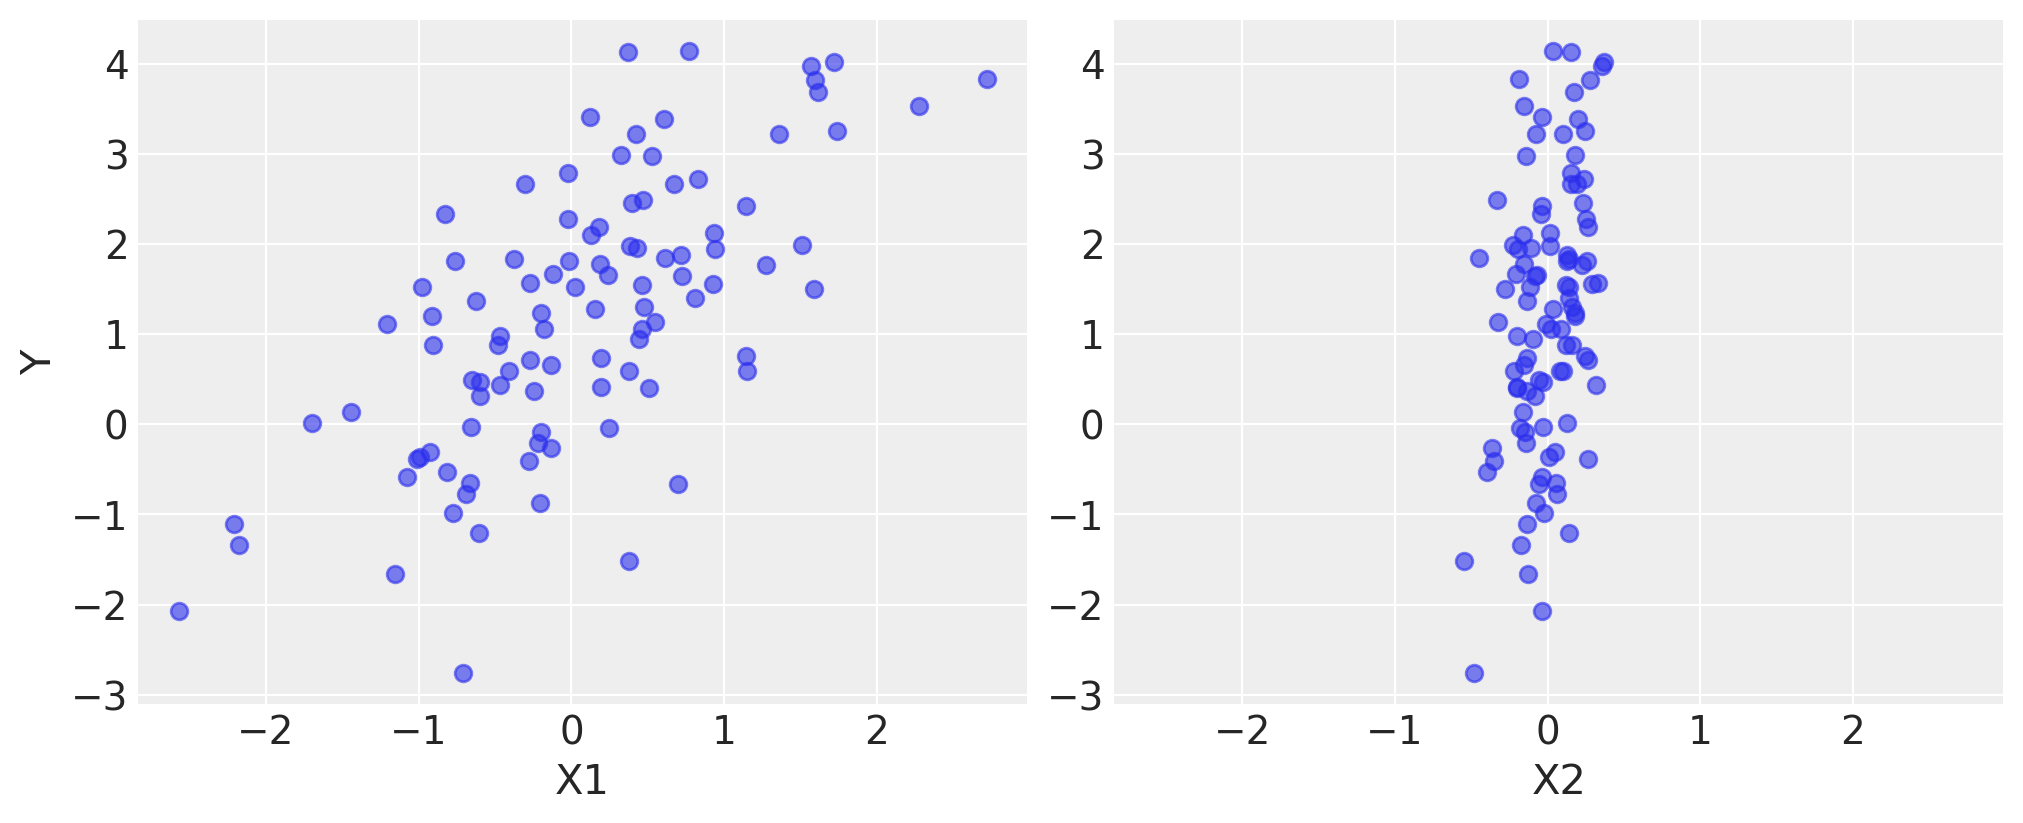

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

Model Specification

In [6]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.20.0


In [7]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)